In [2]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mat_utils import *
from block_matrix import *
from experiments.thermal.thm_models import make_model
import porepy as pp


model = make_model(
    {
        "geometry": 3,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0, Dt: 0.5
sticking: 258, sliding: 0, open: 0


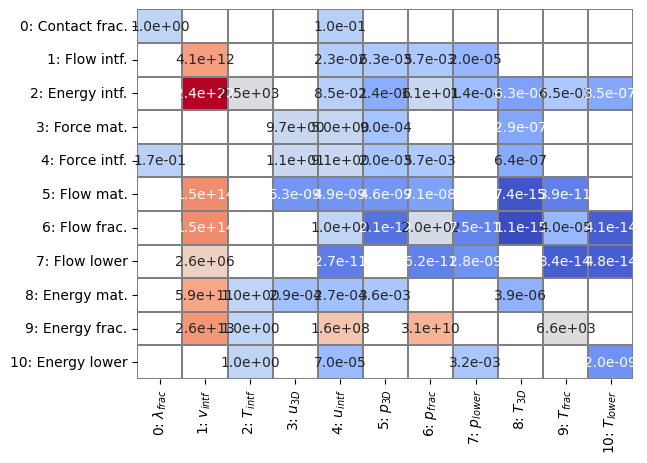

In [3]:
data = load_data(f"../../stats/{model.simulation_name()}.json")
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    data, 1, "../../matrices"
)
model.linear_system = mat, rhs
model.bmat.mat = mat
J = model.bmat[:]
J.plot_max()

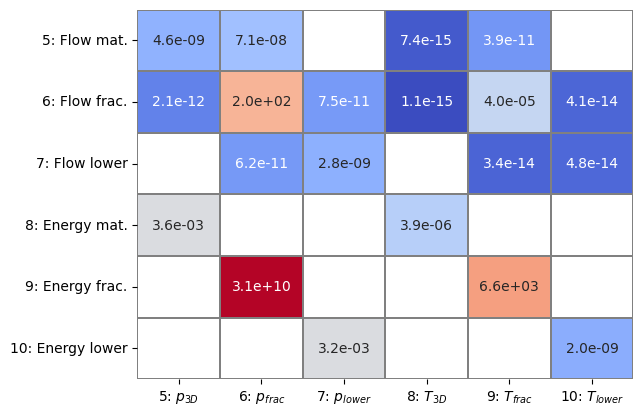

In [38]:
J[[5,6,7,8,9,10]].plot_max()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


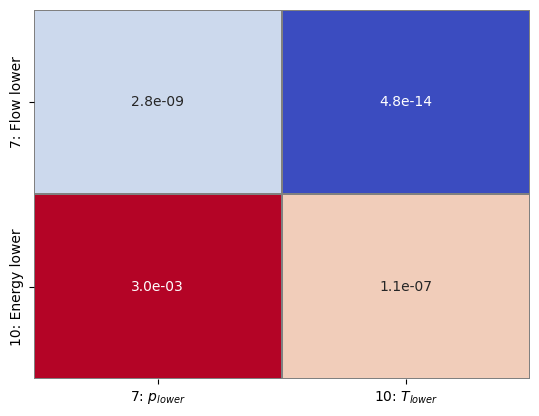

In [42]:
def make_right_decoupling_operator(
    bmat: BlockMatrixStorage, groups0: list[int], groups1: list[int]
) -> BlockMatrixStorage:
    J55_inv = inv_block_diag(bmat[groups1, groups1].mat, nd=1, lump=False)
    # J55_inv = inv(J[group1, group1].mat)
    Qright = bmat.empty_container()[sorted(bmat.active_groups[0])]
    Qright.mat = csr_ones(Qright.shape[0])

    Qright[groups1, groups0] = -J55_inv @ J[groups1, groups0].mat

    return Qright


def make_left_decoupling_operator(
    bmat: BlockMatrixStorage, groups0: list[int], groups1: list[int]
) -> BlockMatrixStorage:
    J55_inv = inv_block_diag(bmat[groups1, groups1].mat, nd=1, lump=False)
    # J55_inv = inv(J[group1, group1].mat)
    Qleft = J.empty_container()[sorted(bmat.active_groups[0])]
    Qleft.mat = csr_ones(Qleft.shape[0])
    Qleft[groups0, groups1] = -bmat[groups0, groups1].mat @ J55_inv
    return Qleft


p = 7
t = 10


Qr = make_right_decoupling_operator(J, groups0=p, groups1=t)[[p, t]]
Ql = make_left_decoupling_operator(J, groups0=p, groups1=t)[[p, t]]

tmp = J[[p, t]]
tmp.mat = Ql.mat @ tmp.mat
# tmp.mat @= Qr.mat
tmp.plot_max()
# tmp.matshow_blocks(log=False)

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *

fact_type = "upper"

p = [6, 7] 
t = [9, 10]


solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        right_transformations=[
            # lambda bmat: make_right_decoupling_operator(bmat, groups0=t, groups1=p),
        ],
        left_transformations=[
            # lambda bmat: make_left_decoupling_operator(bmat, groups0=p, groups1=t),
        ],
        preconditioner=MultiStageScheme(
            groups=p + t,
            stages=[
                lambda bmat: RestrictedOperator(
                    bmat,
                    FieldSplitScheme(
                        groups=p, solve=lambda bmat: PetscAMGFlow(bmat.mat)
                    ),
                ),
                lambda bmat: PetscILU(bmat.mat, factor_levels=3),
            ],
        ),
    ),
)